<a href="https://colab.research.google.com/github/gaixen/RebalanceAI_-241027-/blob/main/notebooka6716da0ab_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing dependencies

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from gym import spaces
import random
from collections import deque, namedtuple
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

All libraries imported successfully!
PyTorch version: 2.6.0+cu124
Device available: CUDA


## Fetching the data

In [3]:
# %%
# Data fetching function
def fetch_data(symbols, start_date, end_date):
    """Fetch data for multiple symbols"""
    all_data = []
    for symbol in symbols:
        try:
            df = yf.download(symbol, start=start_date, end=end_date)
            df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
            df['Symbol'] = symbol
            all_data.append(df)
            print(f"✓ Fetched {len(df)} records for {symbol}")
        except Exception as e:
            print(f"✗ Error fetching {symbol}: {e}")

    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\n📊 Total combined records: {len(combined_df)}")
        return combined_df.reset_index(drop=True) # Reset index here
    return pd.DataFrame()

# %%
# Technical indicators function
def add_indicators(df):
    """Add comprehensive technical indicators to stock DataFrame."""
    import numpy as np
    print("Adding technical indicators...")
    result_dfs = []

    for symbol in df['Symbol'].unique():
        symbol_df = df[df['Symbol'] == symbol].copy()
        print(f"Processing {symbol}...")

        # Moving Averages
        symbol_df['SMA_10'] = symbol_df['Close'].rolling(window=10).mean()
        symbol_df['SMA_20'] = symbol_df['Close'].rolling(window=20).mean()
        symbol_df['EMA_12'] = symbol_df['Close'].ewm(span=12, adjust=False).mean()
        symbol_df['EMA_26'] = symbol_df['Close'].ewm(span=26, adjust=False).mean()

        # RSI
        delta = symbol_df['Close'].diff()
        gain = delta.clip(lower=0).rolling(window=14).mean()
        loss = -delta.clip(upper=0).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)  # avoid divide by zero
        symbol_df['RSI'] = 100 - (100 / (1 + rs))

        # MACD
        symbol_df['MACD'] = symbol_df['EMA_12'] - symbol_df['EMA_26']
        symbol_df['MACD_Signal'] = symbol_df['MACD'].ewm(span=9, adjust=False).mean()
        symbol_df['MACD_Hist'] = symbol_df['MACD'] - symbol_df['MACD_Signal']

        # Bollinger Bands
        sma20 = symbol_df['Close'].rolling(window=20).mean()
        std20 = symbol_df['Close'].rolling(window=20).std()
        symbol_df['BB_Upper'] = sma20 + (2 * std20)
        symbol_df['BB_Lower'] = sma20 - (2 * std20)
        symbol_df['BB_Width'] = (symbol_df['BB_Upper'] - symbol_df['BB_Lower']) / sma20
        symbol_df['BB_Position'] = (symbol_df['Close'] - symbol_df['BB_Lower']) / (symbol_df['BB_Upper'] - symbol_df['BB_Lower'] + 1e-10)

        # ATR (Average True Range)
        high_low = symbol_df['High'] - symbol_df['Low']
        high_close = (symbol_df['High'] - symbol_df['Close'].shift()).abs()
        low_close = (symbol_df['Low'] - symbol_df['Close'].shift()).abs()
        true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        symbol_df['ATR'] = true_range.rolling(window=14).mean()

        # Stochastic Oscillator
        low14 = symbol_df['Low'].rolling(window=14).min()
        high14 = symbol_df['High'].rolling(window=14).max()
        denom = (high14 - low14).replace(0, 1e-10)
        symbol_df['Stoch_K'] = 100 * ((symbol_df['Close'] - low14) / denom)
        symbol_df['Stoch_D'] = symbol_df['Stoch_K'].rolling(window=3).mean()

        # Momentum
        symbol_df['Momentum'] = symbol_df['Close'] / symbol_df['Close'].shift(10) - 1
        symbol_df['ROC'] = symbol_df['Close'].pct_change(10) * 100

        # Volume-based
        symbol_df['Volume_SMA'] = symbol_df['Volume'].rolling(window=20).mean()
        symbol_df['Volume_Ratio'] = symbol_df['Volume'] / (symbol_df['Volume_SMA'] + 1e-10)

        # Price position in recent range
        low_20 = symbol_df['Low'].rolling(window=20).min()
        high_20 = symbol_df['High'].rolling(window=20).max()
        denom_pos = (high_20 - low_20).replace(0, 1e-10)
        symbol_df['Price_Position'] = (symbol_df['Close'] - low_20) / denom_pos

        # Volatility
        symbol_df['Volatility'] = symbol_df['Close'].pct_change().rolling(20).std()

        # Drop NaNs and add symbol's enriched data
        symbol_df = symbol_df.dropna()
        result_dfs.append(symbol_df)

    final_df = pd.concat(result_dfs, ignore_index=True)
    print(f"✓ Technical indicators added. Final dataset: {len(final_df)} records")
    return final_df


## Environment and agents


In [4]:
# %%
# Enhanced Trading Environment
class AdvancedTradingEnv(gym.Env):
    """Enhanced Gym environment for multi-stock trading"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, initial_balance=10000, max_steps=200, normalize=True):
        super(AdvancedTradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.max_steps = min(max_steps, len(df) - 1)
        self.normalize = normalize

        # Shuffle the data to mix different stocks
        self.df = self.df.sample(frac=1).reset_index(drop=True)

        # Feature columns (excluding non-feature columns)
        self.feature_columns = [
            'Close', 'Volume', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26',
            'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Lower',
            'BB_Width', 'BB_Position', 'ATR', 'Stoch_K', 'Stoch_D',
            'Momentum', 'ROC', 'Volume_Ratio', 'Price_Position', 'Volatility'
        ]

        # Normalize features if requested
        if self.normalize:
            self.scaler = StandardScaler()
            self.df[self.feature_columns] = self.scaler.fit_transform(self.df[self.feature_columns])

        # Actions: 0 = hold, 1 = buy, 2 = sell
        self.action_space = spaces.Discrete(3)

        # Observation space: features + portfolio state
        n_features = len(self.feature_columns) + 3  # +3 for shares_held, balance, net_worth
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(n_features,), dtype=np.float32
        )

    def reset(self):
        self.balance = float(self.initial_balance)
        self.net_worth = float(self.initial_balance)
        self.shares_held = 0
        self.current_step = 0
        self.previous_net_worth = self.initial_balance
        return self._get_obs()

    def _get_obs(self):
        if self.current_step >= len(self.df):
            self.current_step = len(self.df) - 1

        row = self.df.iloc[self.current_step]

        # Get feature values
        features = [row[col] for col in self.feature_columns]

        # Add portfolio state (normalized)
        portfolio_features = [
            self.shares_held / 100,  # Normalize shares
            (self.balance - self.initial_balance) / self.initial_balance,  # Normalize balance
            (self.net_worth - self.initial_balance) / self.initial_balance  # Normalize net worth
        ]

        obs = np.array(features + portfolio_features, dtype=np.float32)
        return obs

    def step(self, action):
        if self.current_step >= len(self.df) - 1:
            return self._get_obs(), 0, True, {}

        row = self.df.iloc[self.current_step]
        price = row['Close']

        # Denormalize price if needed
        if self.normalize:
            close_idx = self.feature_columns.index('Close')
            price_array = np.zeros((1, len(self.feature_columns)))
            price_array[0, close_idx] = price
            original_price = self.scaler.inverse_transform(price_array)[0, close_idx]
        else:
            original_price = price

        prev_net_worth = self.net_worth

        # Execute action
        if action == 1 and self.balance >= original_price:  # Buy
            shares_to_buy = int(self.balance // original_price)
            if shares_to_buy > 0:
                self.shares_held += shares_to_buy
                self.balance -= shares_to_buy * original_price
        elif action == 2 and self.shares_held > 0:  # Sell
            self.balance += self.shares_held * original_price
            self.shares_held = 0

        # Move to next step
        self.current_step += 1
        done = self.current_step >= self.max_steps or self.current_step >= len(self.df) - 1

        # Calculate new net worth
        if not done:
            next_row = self.df.iloc[self.current_step]
            next_price = next_row['Close']
            if self.normalize:
                next_price_array = np.zeros((1, len(self.feature_columns)))
                next_price_array[0, close_idx] = next_price
                next_original_price = self.scaler.inverse_transform(next_price_array)[0, close_idx]
            else:
                next_original_price = next_price
            self.net_worth = self.balance + self.shares_held * next_original_price
        else:
            self.net_worth = self.balance + self.shares_held * original_price

        # Calculate reward
        raw_reward = self.net_worth - prev_net_worth
        reward = raw_reward / self.initial_balance * 100  # Percentage-based reward

        # Penalty for excessive trading
        if action != 0:
            reward -= 0.1  # Small transaction cost

        self.previous_net_worth = self.net_worth

        obs = self._get_obs()
        return obs, reward, done, {'net_worth': self.net_worth, 'balance': self.balance, 'shares': self.shares_held}

In [5]:
class ImprovedDQN(nn.Module):
    """Enhanced DQN with Dueling architecture"""
    def __init__(self, input_dim, action_dim, hidden_dim=512):
        super(ImprovedDQN, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(0.2),
        )

        self.value_head = nn.Linear(hidden_dim // 2, 1)
        self.advantage_head = nn.Linear(hidden_dim // 2, action_dim)

    def forward(self, x):
        features = self.feature_extractor(x)

        # Dueling DQN architecture
        value = self.value_head(features)
        advantage = self.advantage_head(features)

        # Combine value and advantage
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

print("✓ Enhanced DQN architecture defined")

✓ Enhanced DQN architecture defined


In [6]:
# %%
# Prioritized Experience Replay Buffer
class PrioritizedReplayBuffer:
    def __init__(self, capacity=50000, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.pos = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)

    def push(self, state, action, reward, next_state, done):
        max_prio = self.priorities.max() if self.buffer else 1.0

        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)

        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]

        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        return samples, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, prio in zip(indices, priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)

print("✓ Prioritized Experience Replay implemented")

✓ Prioritized Experience Replay implemented


## Training

### Fetching the data

In [7]:
# symbols = ['META']
symbols = ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AMZN', 'NVDA', 'META' , 'NFLX']
print(f"Training symbols: {symbols}")

df = fetch_data(symbols, '2018-01-01', '2023-01-01')

if df.empty:
    print("No data fetched.")
else:
    print(f"✅ Successfully fetched data for {len(df['Symbol'].unique())} symbols")

Training symbols: ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AMZN', 'NVDA', 'META', 'NFLX']


[*********************100%***********************]  1 of 1 completed


✓ Fetched 1259 records for AAPL


[*********************100%***********************]  1 of 1 completed


✓ Fetched 1259 records for GOOGL


[*********************100%***********************]  1 of 1 completed


✓ Fetched 1259 records for MSFT


[*********************100%***********************]  1 of 1 completed


✓ Fetched 1259 records for TSLA


[*********************100%***********************]  1 of 1 completed


✓ Fetched 1259 records for AMZN


[*********************100%***********************]  1 of 1 completed


✓ Fetched 1259 records for NVDA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

✓ Fetched 1259 records for META
✓ Fetched 1259 records for NFLX

📊 Total combined records: 10072
✅ Successfully fetched data for 8 symbols


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10072 entries, 0 to 10071
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Open, AAPL)     1259 non-null   float64
 1   (High, AAPL)     1259 non-null   float64
 2   (Low, AAPL)      1259 non-null   float64
 3   (Close, AAPL)    1259 non-null   float64
 4   (Volume, AAPL)   1259 non-null   float64
 5   (Symbol, )       10072 non-null  object 
 6   (Open, GOOGL)    1259 non-null   float64
 7   (High, GOOGL)    1259 non-null   float64
 8   (Low, GOOGL)     1259 non-null   float64
 9   (Close, GOOGL)   1259 non-null   float64
 10  (Volume, GOOGL)  1259 non-null   float64
 11  (Open, MSFT)     1259 non-null   float64
 12  (High, MSFT)     1259 non-null   float64
 13  (Low, MSFT)      1259 non-null   float64
 14  (Close, MSFT)    1259 non-null   float64
 15  (Volume, MSFT)   1259 non-null   float64
 16  (Open, TSLA)     1259 non-null   float64
 17  (High, TSLA)

### Adding the indicators

In [9]:
def melt_stock_data(df):
    """Convert wide-format stock DataFrame to long-format."""
    df.columns = pd.MultiIndex.from_tuples([eval(col) if isinstance(col, str) else col for col in df.columns])

    symbols = sorted(set(sym for (_, sym) in df.columns if sym not in (None, '')))
    long_df = []

    for sym in symbols:
        sym_df = df.xs(key=sym, axis=1, level=1).copy()
        sym_df['Symbol'] = sym
        sym_df['Date'] = df.index
        long_df.append(sym_df)

    final_df = pd.concat(long_df, ignore_index=True)
    final_df = final_df[['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume']]
    return final_df

In [10]:
df_melted = melt_stock_data(df)
df_with_indicators = add_indicators(df_melted)

Adding technical indicators...
Processing AAPL...
Processing AMZN...
Processing GOOGL...
Processing META...
Processing MSFT...
Processing NFLX...
Processing NVDA...
Processing TSLA...
✓ Technical indicators added. Final dataset: 9912 records


In [11]:
print(f"📈 Dataset ready with {len(df_with_indicators.columns)} features")
print(f"Feature columns: {df_with_indicators.columns.tolist()}")

# Display sample data
print("\n📊 Sample of processed data:")
print(df_with_indicators.head())

📈 Dataset ready with 28 features
Feature columns: ['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'ATR', 'Stoch_K', 'Stoch_D', 'Momentum', 'ROC', 'Volume_SMA', 'Volume_Ratio', 'Price_Position', 'Volatility']

📊 Sample of processed data:
   Date Symbol       Open       High        Low      Close       Volume  \
0    20   AAPL  39.161870  39.530327  39.075038  39.293293  129915600.0   
1    21   AAPL  39.232285  39.572577  39.136063  39.375443  188923200.0   
2    22   AAPL  38.957690  39.145439  37.573051  37.666924  346375200.0   
3    23   AAPL  37.338373  38.460167  36.610848  36.725845  290954000.0   
4    24   AAPL  36.336262  38.422610  36.141473  38.260677  272975200.0   

      SMA_10     SMA_20     EMA_12  ...  BB_Position       ATR    Stoch_K  \
0  40.623022  40.856886  40.334647  ...     0.046832  0.658962  17.727183   
1  40.35360

## Training the model

In [12]:
# Training function
def train_multi_stock_dqn(df, episodes=1000, max_steps=300):
    """Train the multi-stock DQN"""

    # Hyperparameters
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_end = 0.05
    epsilon_decay = 0.995
    batch_size = 128
    target_update = 20
    learning_rate = 1e-4

    print(f"🎯 Training Configuration:")
    print(f"   Episodes: {episodes}")
    print(f"   Max steps per episode: {max_steps}")
    print(f"   Batch size: {batch_size}")
    print(f"   Learning rate: {learning_rate}")

    # Initialize environment
    env = AdvancedTradingEnv(df, initial_balance=10000, max_steps=max_steps, normalize=True)
    print(f"   Observation space: {env.observation_space.shape}")
    print(f"   Action space: {env.action_space.n}")

    # Initialize networks
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"   Device: {device}")

    policy_net = ImprovedDQN(env.observation_space.shape[0], env.action_space.n).to(device)
    target_net = ImprovedDQN(env.observation_space.shape[0], env.action_space.n).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
    memory = PrioritizedReplayBuffer(capacity=50000)

    # Training loop
    epsilon = epsilon_start
    episode_rewards = []
    episode_net_worths = []
    best_reward = float('-inf')

    print("\n🏋️ Starting training...")

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps):
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = random.randrange(env.action_space.n)
            else:
                policy_net.eval() # Set policy_net to evaluation mode
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax().item()
                policy_net.train() # Set policy_net back to training mode


            next_state, reward, done, info = env.step(action)
            memory.push(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            # Training
            if len(memory) >= batch_size:
                samples, indices, weights = memory.sample(batch_size)

                states = torch.FloatTensor([s[0] for s in samples]).to(device)
                actions = torch.LongTensor([s[1] for s in samples]).to(device)
                rewards = torch.FloatTensor([s[2] for s in samples]).to(device)
                next_states = torch.FloatTensor([s[3] for s in samples]).to(device)
                dones = torch.BoolTensor([s[4] for s in samples]).to(device)
                weights_tensor = torch.FloatTensor(weights).to(device)

                current_q_values = policy_net(states).gather(1, actions.unsqueeze(1))
                next_q_values = target_net(next_states).max(1)[0].detach()
                target_q_values = rewards + (gamma * next_q_values * ~dones)

                # Compute loss with importance sampling weights
                td_errors = current_q_values.squeeze() - target_q_values
                loss = (weights_tensor * td_errors.pow(2)).mean()

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()

                # Update priorities
                priorities = np.abs(td_errors.detach().cpu().numpy()) + 1e-6
                memory.update_priorities(indices, priorities)

            if done:
                break

        # Update target network
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Decay epsilon and update scheduler
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        scheduler.step()

        # Track performance
        episode_rewards.append(total_reward)
        episode_net_worths.append(info.get('net_worth', env.initial_balance))

        # Save best model

        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(policy_net.state_dict(), 'best_dqn_model.pth')

        # Progress reporting
        if episode % 10 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            avg_net_worth = np.mean(episode_net_worths[-50:])
            print(f"Episode {episode:4d}/{episodes} | "
                  f"Avg Reward: {avg_reward:8.2f} | "
                  f"Avg Net Worth: ${avg_net_worth:8.2f} | "
                  f"Epsilon: {epsilon:.3f} | "
                  f"Buffer: {len(memory):5d}")

    print("✅ Training completed!")
    return policy_net, env, episode_rewards, episode_net_worths

In [13]:
trained_model, trained_env, training_rewards, training_net_worths = train_multi_stock_dqn(
    df_with_indicators,
    episodes=800,
    max_steps=250
)

🎯 Training Configuration:
   Episodes: 800
   Max steps per episode: 250
   Batch size: 128
   Learning rate: 0.0001
   Observation space: (25,)
   Action space: 3
   Device: cuda

🏋️ Starting training...
Episode    0/800 | Avg Reward:  -113.22 | Avg Net Worth: $  387.85 | Epsilon: 0.995 | Buffer:   250
Episode   10/800 | Avg Reward: 129143366049.93 | Avg Net Worth: $12914336616719.36 | Epsilon: 0.946 | Buffer:  2750
Episode   20/800 | Avg Reward: 67655250509.34 | Avg Net Worth: $6765525062633.33 | Epsilon: 0.900 | Buffer:  5250
Episode   30/800 | Avg Reward: 45946443123.71 | Avg Net Worth: $4594644324071.96 | Epsilon: 0.856 | Buffer:  7750
Episode   40/800 | Avg Reward: 34740344681.88 | Avg Net Worth: $3474034479880.90 | Epsilon: 0.814 | Buffer: 10250
Episode   50/800 | Avg Reward: 28495624418.44 | Avg Net Worth: $2849562453537.56 | Epsilon: 0.774 | Buffer: 12750
Episode   60/800 | Avg Reward: 49400291566.17 | Avg Net Worth: $4940029168299.03 | Epsilon: 0.737 | Buffer: 15250
Episode  

### Evaluation

In [16]:
def evaluate_model(policy_net, test_symbols, start_date, end_date):
    # Fetch test data
    test_df = fetch_data(test_symbols, start_date, end_date)
    test_df = melt_stock_data(test_df)
    test_df = add_indicators(test_df)

    # Create test environment
    test_env = AdvancedTradingEnv(test_df, initial_balance=10000, max_steps=200, normalize=True)

    # Test the trained model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    state = test_env.reset()
    dqn_values = [test_env.initial_balance]
    actions_taken = []

    policy_net.eval()
    with torch.no_grad():
        for step in range(test_env.max_steps):
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = policy_net(state_tensor)
            action = q_values.argmax().item()

            state, _, done, _ = test_env.step(action)
            dqn_values.append(test_env.net_worth)
            actions_taken.append(action)

            if done:
                break

    # Calculate buy-and-hold baseline
    test_prices = []
    for i in range(len(dqn_values)):
        if i < len(test_df):
            price = test_df.iloc[i]['Close']
            if test_env.normalize:
                close_idx = test_env.feature_columns.index('Close')
                price_array = np.zeros((1, len(test_env.feature_columns)))
                price_array[0, close_idx] = price
                original_price = test_env.scaler.inverse_transform(price_array)[0, close_idx]
            else:
                original_price = price
            test_prices.append(original_price)

    if test_prices:
        buy_hold_values = [(price / test_prices[0]) * test_env.initial_balance for price in test_prices]
    else:
        buy_hold_values = [test_env.initial_balance] * len(dqn_values)

    print(f"✅ Evaluation completed on {len(dqn_values)} time steps")
    return dqn_values, buy_hold_values, actions_taken

In [17]:
# Evaluate on test data
test_symbols = ['AAPL', 'GOOGL', 'MSFT']  # Subset for testing
dqn_values, buy_hold_values, actions = evaluate_model(
    trained_model, test_symbols, '2023-01-01', '2024-01-01'
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✓ Fetched 250 records for AAPL
✓ Fetched 250 records for GOOGL
✓ Fetched 250 records for MSFT

📊 Total combined records: 750
Adding technical indicators...
Processing AAPL...
Processing GOOGL...
Processing MSFT...
✓ Technical indicators added. Final dataset: 690 records
✅ Evaluation completed on 201 time steps


In [18]:
def plot_comprehensive_results(dqn_values, buy_hold_values, training_rewards, actions):
    """Plot comprehensive results with multiple metrics"""

    fig = plt.figure(figsize=(20, 15))

    # 1. Portfolio Value Comparison
    ax1 = plt.subplot(2, 3, 1)
    plt.plot(dqn_values, label='DQN Agent', linewidth=2.5, color='#2E8B57')
    plt.plot(buy_hold_values, label='Buy & Hold', linewidth=2.5, color='#FF6347')
    plt.title('Portfolio Value Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Time Steps')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Training Progress
    ax2 = plt.subplot(2, 3, 2)
    plt.plot(training_rewards, alpha=0.6, color='lightblue')
    smoothed = pd.Series(training_rewards).rolling(50).mean()
    plt.plot(smoothed, color='darkblue', linewidth=2)
    plt.title('Training Rewards Over Episodes', fontsize=14, fontweight='bold')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True, alpha=0.3)

    # 3. Action Distribution
    ax3 = plt.subplot(2, 3, 3)
    action_names = ['Hold', 'Buy', 'Sell']
    action_counts = [actions.count(i) for i in range(3)]
    colors = ['#FFD700', '#32CD32', '#FF4500']
    plt.pie(action_counts, labels=action_names, autopct='%1.1f%%', colors=colors)
    plt.title('Action Distribution', fontsize=14, fontweight='bold')

    # 4. Performance Metrics Bar Chart
    ax4 = plt.subplot(2, 3, 4)
    dqn_return = (dqn_values[-1] - dqn_values[0]) / dqn_values[0] * 100
    bh_return = (buy_hold_values[-1] - buy_hold_values[0]) / buy_hold_values[0] * 100

    metrics = ['Total Return (%)', 'Final Value ($)', 'Max Value ($)']
    dqn_metrics = [dqn_return, dqn_values[-1], max(dqn_values)]
    bh_metrics = [bh_return, buy_hold_values[-1], max(buy_hold_values)]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, dqn_metrics, width, label='DQN Agent', alpha=0.8, color='#2E8B57')
    plt.bar(x + width/2, bh_metrics, width, label='Buy & Hold', alpha=0.8, color='#FF6347')
    plt.title('Performance Metrics', fontsize=14, fontweight='bold')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 5. Return Distribution
    ax5 = plt.subplot(2, 3, 5)
    dqn_returns = np.diff(dqn_values) / dqn_values[:-1]
    bh_returns = np.diff(buy_hold_values) / buy_hold_values[:-1]

    plt.hist(dqn_returns, bins=30, alpha=0.7, label='DQN Returns', density=True, color='#2E8B57')
    plt.hist(bh_returns, bins=30, alpha=0.7, label='Buy & Hold Returns', density=True, color='#FF6347')
    plt.title('Return Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 6. Cumulative Returns
    ax6 = plt.subplot(2, 3, 6)
    dqn_cum_returns = np.cumprod(1 + dqn_returns) - 1
    bh_cum_returns = np.cumprod(1 + bh_returns) - 1

    plt.plot(dqn_cum_returns * 100, label='DQN Cumulative Returns', linewidth=2, color='#2E8B57')
    plt.plot(bh_cum_returns * 100, label='Buy & Hold Cumulative Returns', linewidth=2, color='#FF6347')
    plt.title('Cumulative Returns (%)', fontsize=14, fontweight='bold')
    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative Return (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Calculate and display metrics
    dqn_volatility = np.std(dqn_returns) * np.sqrt(252)  # Annualized
    bh_volatility = np.std(bh_returns) * np.sqrt(252)

    dqn_sharpe = (np.mean(dqn_returns) * 252) / dqn_volatility if dqn_volatility > 0 else 0
    bh_sharpe = (np.mean(bh_returns) * 252) / bh_volatility if bh_volatility > 0 else 0

    # Calculate additional metrics
    dqn_max_drawdown = calculate_max_drawdown(dqn_values)
    bh_max_drawdown = calculate_max_drawdown(buy_hold_values)

    # Calculate win rate for DQN
    positive_returns = sum(1 for r in dqn_returns if r > 0)
    win_rate = positive_returns / len(dqn_returns) * 100 if len(dqn_returns) > 0 else 0

    # Print comprehensive metrics summary
    print("\n" + "="*60)
    print("COMPREHENSIVE PERFORMANCE ANALYSIS")
    print("="*60)

    print(f"\n📊 PORTFOLIO PERFORMANCE:")
    print(f"{'Metric':<25} {'DQN Agent':<15} {'Buy & Hold':<15} {'Difference':<15}")
    print("-" * 70)
    print(f"{'Total Return (%)':<25} {dqn_return:<15.2f} {bh_return:<15.2f} {dqn_return - bh_return:<15.2f}")
    print(f"{'Final Value ($)':<25} {dqn_values[-1]:<15.2f} {buy_hold_values[-1]:<15.2f} {dqn_values[-1] - buy_hold_values[-1]:<15.2f}")
    print(f"{'Maximum Value ($)':<25} {max(dqn_values):<15.2f} {max(buy_hold_values):<15.2f} {max(dqn_values) - max(buy_hold_values):<15.2f}")

    print(f"\n📈 RISK METRICS:")
    print(f"{'Volatility (Annual %)':<25} {dqn_volatility*100:<15.2f} {bh_volatility*100:<15.2f} {(dqn_volatility-bh_volatility)*100:<15.2f}")
    print(f"{'Sharpe Ratio':<25} {dqn_sharpe:<15.2f} {bh_sharpe:<15.2f} {dqn_sharpe - bh_sharpe:<15.2f}")
    print(f"{'Max Drawdown (%)':<25} {dqn_max_drawdown:<15.2f} {bh_max_drawdown:<15.2f} {dqn_max_drawdown - bh_max_drawdown:<15.2f}")

    print(f"\n🎯 TRADING BEHAVIOR:")
    print(f"Win Rate (DQN): {win_rate:.1f}%")
    print(f"Total Actions: {len(actions)}")
    print(f"  - Hold: {action_counts[0]} ({action_counts[0]/len(actions)*100:.1f}%)")
    print(f"  - Buy:  {action_counts[1]} ({action_counts[1]/len(actions)*100:.1f}%)")
    print(f"  - Sell: {action_counts[2]} ({action_counts[2]/len(actions)*100:.1f}%)")

    print(f"\n🏆 SUMMARY:")
    if dqn_return > bh_return:
        outperformance = dqn_return - bh_return
        print(f"✅ DQN Agent OUTPERFORMED Buy & Hold by {outperformance:.2f}%")
    else:
        underperformance = bh_return - dqn_return
        print(f"❌ DQN Agent UNDERPERFORMED Buy & Hold by {underperformance:.2f}%")

    if dqn_sharpe > bh_sharpe:
        print(f"✅ DQN Agent achieved better risk-adjusted returns (Sharpe: {dqn_sharpe:.2f} vs {bh_sharpe:.2f})")
    else:
        print(f"❌ Buy & Hold achieved better risk-adjusted returns (Sharpe: {bh_sharpe:.2f} vs {dqn_sharpe:.2f})")

    print("="*60)

    return {
        'dqn_metrics': {
            'total_return': dqn_return,
            'final_value': dqn_values[-1],
            'max_value': max(dqn_values),
            'volatility': dqn_volatility,
            'sharpe_ratio': dqn_sharpe,
            'max_drawdown': dqn_max_drawdown,
            'win_rate': win_rate
        },
        'bh_metrics': {
            'total_return': bh_return,
            'final_value': buy_hold_values[-1],
            'max_value': max(buy_hold_values),
            'volatility': bh_volatility,
            'sharpe_ratio': bh_sharpe,
            'max_drawdown': bh_max_drawdown
        },
        'action_distribution': dict(zip(action_names, action_counts))
    }


def calculate_max_drawdown(values):
    """Calculate maximum drawdown percentage"""
    peak = values[0]
    max_dd = 0

    for value in values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak * 100
        if drawdown > max_dd:
            max_dd = drawdown

    return max_dd

from scipy.stats import norm

def calculate_var(returns, confidence=0.95):
    return np.percentile(returns, (1 - confidence) * 100)



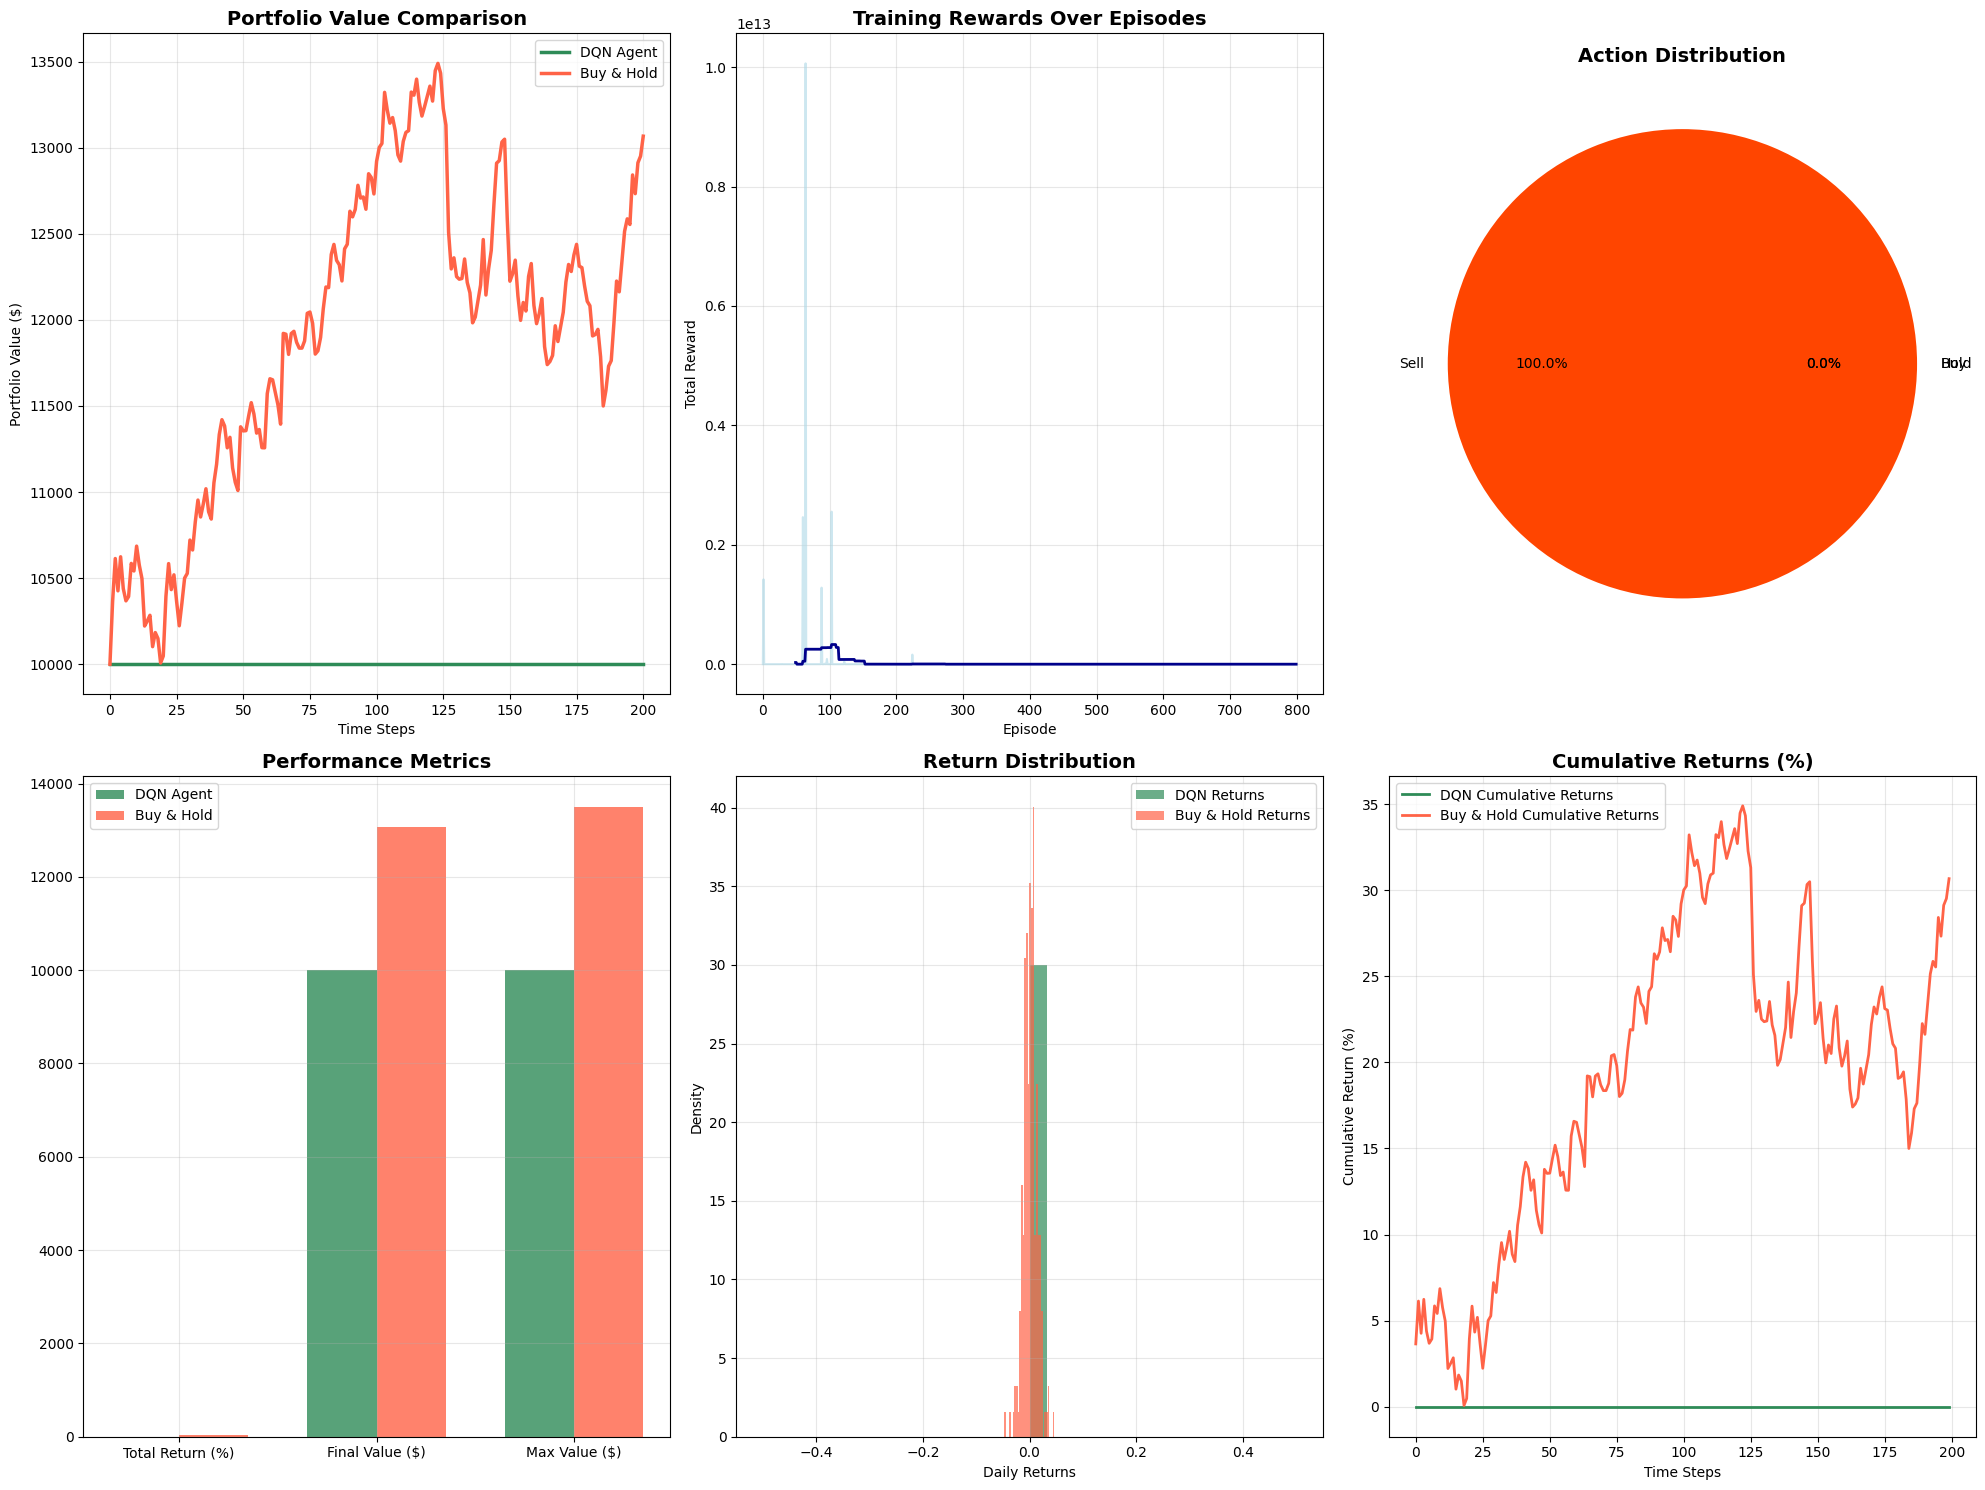


COMPREHENSIVE PERFORMANCE ANALYSIS

📊 PORTFOLIO PERFORMANCE:
Metric                    DQN Agent       Buy & Hold      Difference     
----------------------------------------------------------------------
Total Return (%)          0.00            30.67           -30.67         
Final Value ($)           10000.00        13067.04        -3067.04       
Maximum Value ($)         10000.00        13489.93        -3489.93       

📈 RISK METRICS:
Volatility (Annual %)     0.00            20.28           -20.28         
Sharpe Ratio              0.00            1.76            -1.76          
Max Drawdown (%)          0.00            14.75           -14.75         

🎯 TRADING BEHAVIOR:
Win Rate (DQN): 0.0%
Total Actions: 200
  - Hold: 0 (0.0%)
  - Buy:  0 (0.0%)
  - Sell: 200 (100.0%)

🏆 SUMMARY:
❌ DQN Agent UNDERPERFORMED Buy & Hold by 30.67%
❌ Buy & Hold achieved better risk-adjusted returns (Sharpe: 1.76 vs 0.00)


{'dqn_metrics': {'total_return': np.float64(0.0),
  'final_value': np.float64(10000.0),
  'max_value': 10000,
  'volatility': np.float64(0.0),
  'sharpe_ratio': 0,
  'max_drawdown': 0,
  'win_rate': 0.0},
 'bh_metrics': {'total_return': np.float64(30.670393509344173),
  'final_value': np.float64(13067.039350934418),
  'max_value': np.float64(13489.934939849269),
  'volatility': np.float64(0.20275140050330356),
  'sharpe_ratio': np.float64(1.7648378134403686),
  'max_drawdown': np.float64(14.752570802419246)},
 'action_distribution': {'Hold': 0, 'Buy': 0, 'Sell': 200}}

In [19]:
plot_comprehensive_results(dqn_values, buy_hold_values, training_rewards, actions)